In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import PIL.Image as Image
# i prefer PIL to draw the text, more beautiful
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont

This image is: <class 'numpy.ndarray'> with dimension: (720, 1280, 3)


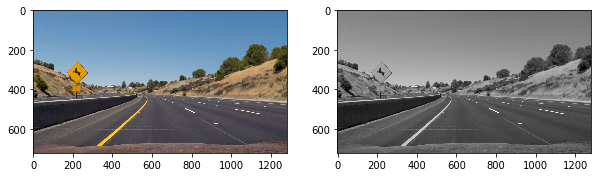

In [2]:
image = cv2.imread('curve-lane.jpg')
print('This image is:', type(image), 'with dimension:', image.shape)
plt.figure(figsize = (10, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), cmap = 'gray')
plt.show()

In [3]:
def select_rgb_white_yellow(image): 
    # white color mask
    lower = np.uint8([200, 200, 200])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower, upper)
    # yellow color mask
    lower = np.uint8([190, 190,   0])
    upper = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked = cv2.bitwise_and(image, image, mask = mask)
    return masked

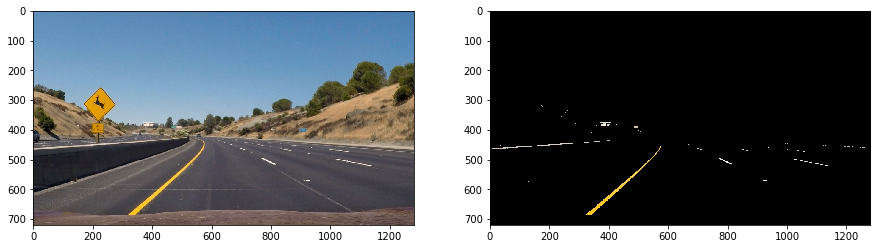

In [4]:
plt.figure(figsize = (15, 10))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(select_rgb_white_yellow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))
plt.show()

In [5]:
rows, cols = image.shape[:2]
bottom_left  = [int(cols*0.05), int(rows*0.95)]
top_left     = [int(cols*0.45), int(rows*0.60)]
bottom_right = [int(cols*0.95), int(rows*0.95)]
top_right    = [int(cols*0.55), int(rows*0.60)]
vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)

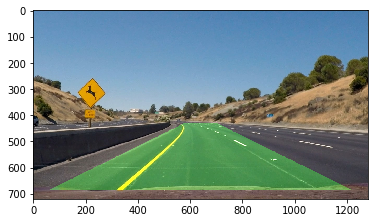

In [6]:
copied = np.copy(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
window_img = np.zeros_like(copied)
polyfill = np.array([bottom_left,bottom_right,top_right,top_left])
cv2.fillPoly(window_img, pts =[polyfill], color=(0,255, 0))
copied = cv2.addWeighted(copied, 1, window_img, 0.3, 0)
plt.imshow(copied)
plt.show()

In [7]:
import math

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255   
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

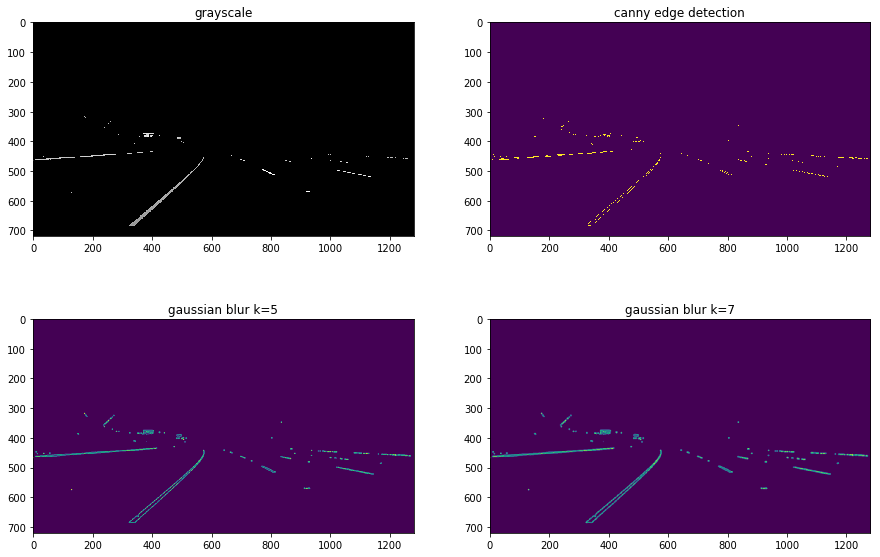

In [8]:
selected_colors = select_rgb_white_yellow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.figure(figsize = (15, 10))

plt.subplot(2, 2, 1)
plt.imshow(grayscale(selected_colors), cmap = 'gray')
plt.title('grayscale')

plt.subplot(2, 2, 2)
plt.imshow(canny(selected_colors, 100, 150))
plt.title('canny edge detection')

plt.subplot(2, 2, 3)
plt.imshow(gaussian_blur(canny(selected_colors, 100, 150), 5))
plt.title('gaussian blur k=5')

plt.subplot(2, 2, 4)
plt.imshow(gaussian_blur(canny(selected_colors, 100, 150), 7))
plt.title('gaussian blur k=7')

plt.show()

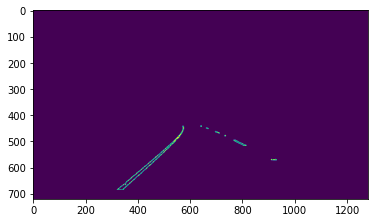

In [9]:
blurred = gaussian_blur(canny(selected_colors, 100, 150), 7)
copied = np.copy(blurred)
plt.imshow(region_of_interest(copied,vertices))
plt.show()

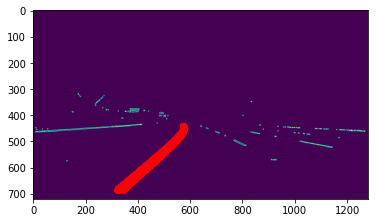

In [10]:
middle_split = 600
interested = region_of_interest(copied,vertices)
where_left = np.where(interested[:,:middle_split]>80)
plt.imshow(blurred)
plt.scatter(where_left[1],where_left[0],color='r')
plt.show()

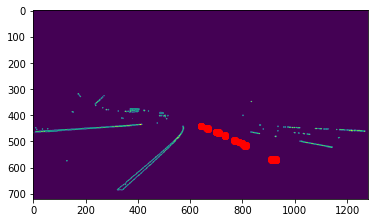

In [11]:
where_right = np.where(interested[:,middle_split:]>80)
plt.imshow(blurred)
plt.scatter(middle_split+where_right[1],where_right[0],color='r')
plt.show()

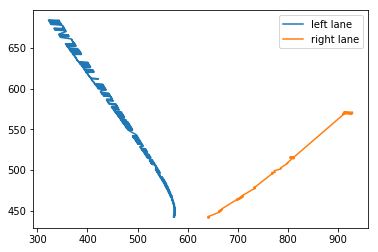

In [12]:
plt.plot(where_left[1][::-1],where_left[0][::-1],label='left lane')
plt.plot(middle_split+where_right[1][::-1],
         where_right[0][::-1],label='right lane')
plt.legend()
plt.show()

In [13]:
x_left, y_left = where_left[1][::-1],where_left[0][::-1]
x_right, y_right = middle_split+where_right[1][::-1],where_right[0][::-1]

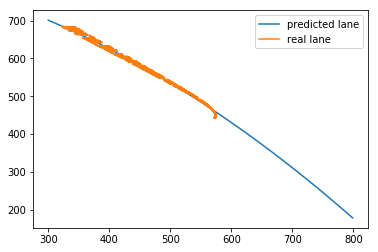

In [14]:
import numpy.polynomial.polynomial as poly

coefs_left = poly.polyfit(x_left, y_left, 2)
x_new_left = np.arange(300,800)
ffit_left = poly.polyval(x_new_left, coefs_left)
plt.plot(x_new_left, ffit_left,label='predicted lane')
plt.plot(x_left, y_left,label='real lane')
plt.legend()
plt.show()

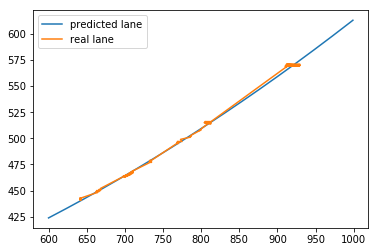

In [15]:
coefs_right = poly.polyfit(x_right, y_right, 2)
x_new_right = np.arange(600,1000)
ffit_right = poly.polyval(x_new_right, coefs_right)
plt.plot(x_new_right, ffit_right,label='predicted lane')
plt.plot(x_right, y_right,label='real lane')
plt.legend()
plt.show()

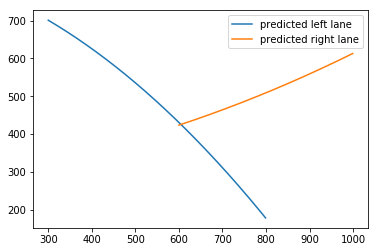

In [16]:
plt.plot(x_new_left,ffit_left,label='predicted left lane')
plt.plot(x_new_right,ffit_right,label='predicted right lane')
plt.legend()
plt.show()

In [17]:
x_new_left = np.arange(np.min(x_left),np.max(x_left))
x_new_right = np.arange(np.min(x_right),np.max(x_right))
ffit_left = poly.polyval(x_new_left, coefs_left)
ffit_right = poly.polyval(x_new_right, coefs_right)

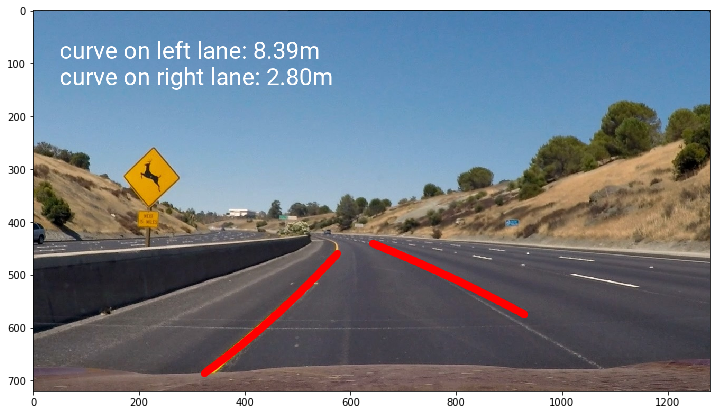

In [18]:
copied = np.copy(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.figure(figsize = (15, 7))

curve_left = 'curve on left lane: %.2fm'%(coefs_left[0]/100)
curve_right = 'curve on right lane: %.2fm'%(coefs_right[0]/100)

pil_image = Image.fromarray(np.uint8(copied))
draw = ImageDraw.Draw(pil_image)
font = ImageFont.truetype('Roboto-Regular.ttf', 45)
draw.text((50,50),curve_left,fill='white',font=font)
draw.text((50,100),curve_right,fill='white',font=font)

plt.imshow(np.array(pil_image))
plt.scatter(x_new_left,ffit_left,color='r')
plt.scatter(x_new_right,ffit_right,color='r')
plt.show()